# WGAN with Conditional Normalizing Flow


In [ ]:
# !git clone https://github.com/medicinely/fwi.git
%cd fwi

/content/fwi


In [ ]:
import os
import time
import numpy as np
import scipy as sc
import scipy.sparse as sp

import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from IPython.display import clear_output
from IPython import display

import tensorflow as tf
from tensorflow.keras import layers
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import func.propagation as prop
import func.velmodel as vmod

device = 'cpu'
labelsize = 16

# from google.colab import drive
# drive.mount('/content/drive')

## Load Dataset

(2816, 40, 120, 1)


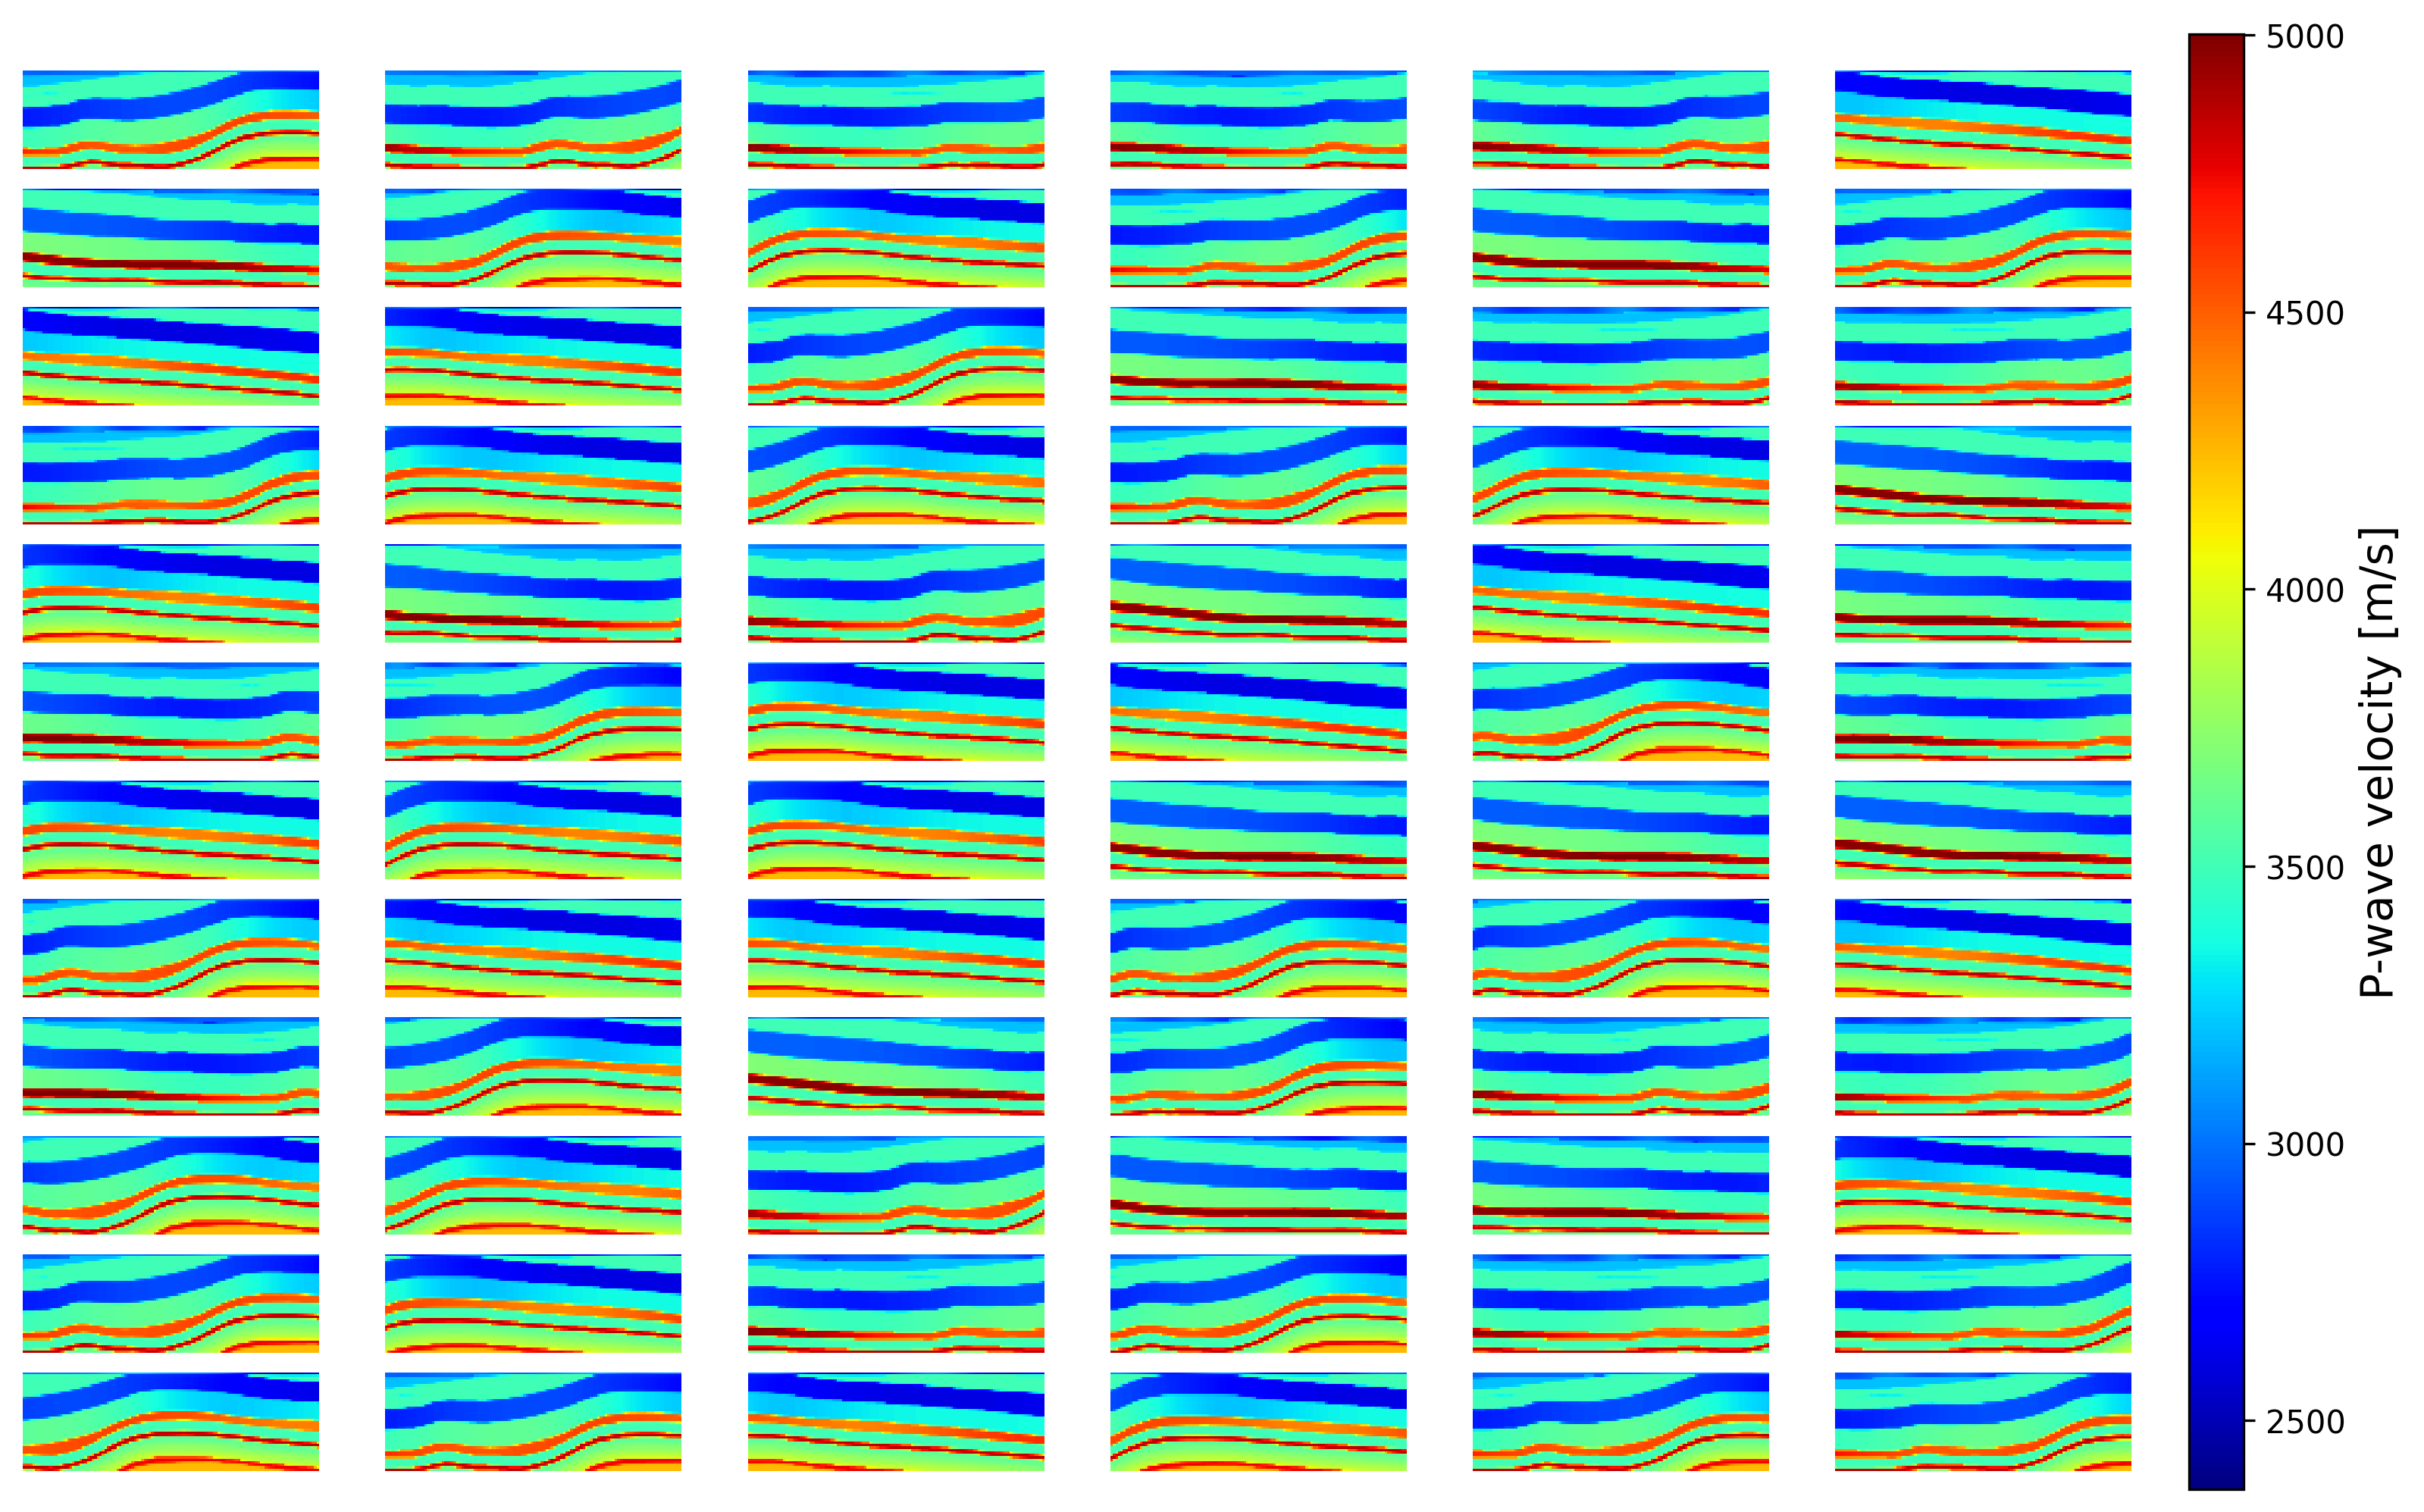

In [ ]:
# n1=93 n2=401 n3=401 d1=d2=d3=50m
vel = vmod.readbin('../dataset/velocity/overthrust.bin',93,401*401)
# vel = vmod.readbin('/content/drive/MyDrive/yxieg/notebook/v.bin',93,401*401)
vel = np.reshape(vel,[93,401,401])
n = 120
vel = vel[:41, :, 60:70]
vmin, vmax = vel.min(), vel.max()

def crop_images(data, crop_size, z_interval, x_interval, y_interval):
    cropped_images = []
    nz, nx, ny = data.shape
    for y in range(0, ny, y_interval):
        for z in range(0, nz - crop_size[0], z_interval):
          for x in range(0, nx - crop_size[1] + 1, x_interval):
              cropped_images.append(data[z:z+crop_size[0], x:x+crop_size[1], y])
    return np.array(cropped_images)

# Given data (replace this with your actual data)
crop_size = (40, 120)  # Crop size [height, width]
z_interval = crop_size[0]//8  # Interval on z-axis
x_interval = crop_size[1]//8 # Interval on x-axis
y_interval = crop_size[1]//8  # Interval on y-axis

z_interval = 1  # Interval on z-axis
x_interval = 1 # Interval on x-axis
y_interval = 1  # Interval on y-axis

# Crop images
cropped_images = crop_images(vel, crop_size, z_interval, x_interval, y_interval)
n_img = cropped_images.shape[0]
cropped_images = cropped_images.reshape(n_img, crop_size[0], crop_size[1], 1).astype('float32')
cropped_images = cropped_images[:int(n_img - n_img%256),:,:,:]

# Upsample the images to the target size
# cropped_images = tf.image.resize(cropped_images, size=(200, 600))
cropped_images = tf.cast(cropped_images, tf.float32)

# Display shape of cropped images
print(cropped_images.shape)

fig = plt.figure(figsize=(12, 8), dpi=300)
for i in range(72):
  plt.subplot(12, 6, i+1)
  plt.imshow(cropped_images[np.random.randint(cropped_images.shape[0]),:,:],cmap='jet',vmin=vmin,vmax=vmax)
  # plt.imshow(cropped_images[i,:,:],cmap='jet',vmin=vmin,vmax=vmax)
  plt.axis('off')
# Add a single colorbar for all subplots
cax = plt.axes([0.92, 0.1, 0.02, 0.8])  # [x, y, width, height]
cb = plt.colorbar(cax=cax)
cb.set_label("P-wave velocity [m/s]", fontsize=14)
# Show the plot
plt.show()


## Normalize images

In [ ]:
train_images = cropped_images.numpy()
# train_images = train_images.reshape(train_images.shape[0], 201, 601, 1).astype('float32')
# train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]
z1,x1 = train_images.shape[1],train_images.shape[2]
vmin, vmax = np.min(train_images),np.max(train_images)

def my_norm(a, min_val, max_val):
    ratio = 2/(max_val - min_val)
    shift = (max_val+min_val)/2
    return (a - shift)*ratio

def inverse_norm(a, min_val, max_val):
    ratio = 2 / (max_val - min_val)
    shift = (max_val + min_val) / 2
    return (a / ratio) + shift

train_images = my_norm(train_images,vmin,vmax)
print(train_images.min(),train_images.max())

BUFFER_SIZE = n_img
BATCH_SIZE = 256
dim_z = 100

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

-0.99999994 0.99999994


## Define Generator and Discriminator

In [ ]:
kernal_size = (5, 5)
kernal_size_2 = (7, 7)

def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(z1*x1//16*256, use_bias=False, input_shape=(dim_z,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((z1//4, x1//4, 256)))
    assert model.output_shape == (None, z1//4, x1//4, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(512, kernal_size, strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, z1//4, x1//4, 512)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    # model.add(PixelShuffle(scale=2))  # Add Pixel Shuffle with scale 2

    model.add(layers.Conv2DTranspose(256, kernal_size, strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, z1//4, x1//4, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, kernal_size, strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, z1//4, x1//4, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, kernal_size, strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, z1//4, x1//4, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, kernal_size, strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, z1//4, x1//4, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, kernal_size, strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, z1//4, x1//4, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, kernal_size, strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, z1//2, x1//2, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, kernal_size, strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, z1, x1, 1)

    return model

def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, kernal_size_2, strides=(2, 2), padding='same',
                                     input_shape=[z1, x1, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(64, kernal_size_2, strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, kernal_size, strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, kernal_size, strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(512, kernal_size, strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(512, kernal_size, strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

# def discriminator_loss(real_output, fake_output):
#     real_loss = cross_entropy(tf.ones_like(real_output), real_output)
#     fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
#     total_loss = real_loss + fake_loss
#     return total_loss

# def generator_loss(fake_output):
#     return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return fake_loss - real_loss

# Define the loss functions for the generator.
def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img)

def gradient_penalty(batch_size, real_images, fake_images):
    """Calculates the gradient penalty.

    This loss is calculated on an interpolated image
    and added to the discriminator loss.
    """
    # Get the interpolated image
    alpha = tf.random.uniform([batch_size, 1, 1, 1], 0.0, 1.0)
    diff = fake_images - real_images
    interpolated = real_images + alpha * diff

    with tf.GradientTape() as gp_tape:
        gp_tape.watch(interpolated)
        # 1. Get the discriminator output for this interpolated image.
        pred = discriminator(interpolated, training=True)

    # 2. Calculate the gradients w.r.t to this interpolated image.
    grads = gp_tape.gradient(pred, [interpolated])[0]
    # 3. Calculate the norm of the gradients.
    norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
    gp = tf.reduce_mean((norm - 1.0) ** 2)
    return gp

# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    # For each batch, we are going to perform the
    # following steps as laid out in the original paper:
    # 1. Train the generator and get the generator loss
    # 2. Train the discriminator and get the discriminator loss
    # 3. Calculate the gradient penalty
    # 4. Multiply this gradient penalty with a constant weight factor
    # 5. Add the gradient penalty to the discriminator loss
    # 6. Return the generator and discriminator losses as a loss dictionary
    extra_step = 5
    weight = 10.0

    # Train the discriminator first. The original paper recommends training
    # the discriminator for `x` more steps (typically 5) as compared to
    # one step of the generator. Here we will train it for 3 extra steps
    # as compared to 5 to reduce the training time.
    for i in range(extra_step):
      # Get the latent vector
      noise = tf.random.normal([BATCH_SIZE, noise_dim])
      with tf.GradientTape() as tape:
        # Generate fake images from the latent vector
        fake_images = generator(noise, training=True)
        # Get the logits for the fake images
        fake_logits = discriminator(fake_images, training=True)
        # Get the logits for the real images
        real_logits = discriminator(images, training=True)

        # Calculate the discriminator loss using the fake and real image logits
        d_cost = discriminator_loss(real_img=real_logits, fake_img=fake_logits)
        # Calculate the gradient penalty
        gp = gradient_penalty(BATCH_SIZE, images, fake_images)
        # Add the gradient penalty to the original discriminator loss
        d_loss = d_cost + gp * weight

      # Get the gradients w.r.t the discriminator loss
      d_gradient = tape.gradient(d_loss, discriminator.trainable_variables)
      # Update the weights of the discriminator using the discriminator optimizer
      discriminator_optimizer.apply_gradients(
          zip(d_gradient, discriminator.trainable_variables)
      )

    # Train the generator
    # Get the latent vector
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return [gen_loss, disc_loss]

def train(dataset, epochs):
  loss_history = []
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      loss = train_step(image_batch)
    loss_history.append(loss)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed,
                             loss_history)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed,
                           loss_history)
  return loss_history

def generate_and_save_images(model, epoch, test_input, loss_history):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  Gz = model(test_input, training=False)

  fig = plt.figure(figsize=(12, 8),dpi=300)
  plt.suptitle(f"Epoch {epoch}")
  for i in range(num_examples_to_generate):
    plt.subplot(10, 5, i+1)
    Gz_i = inverse_norm(Gz[i,:,:,0],vmin,vmax)
    plt.imshow(Gz_i,cmap='jet',vmin=vmin,vmax=vmax)
    plt.axis('off')

  # Add a single colorbar for all subplots
  cax = plt.axes([0.92, 0.1, 0.02, 0.8])  # [x, y, width, height]
  cbar = plt.colorbar(cax=cax)
  cbar.formatter.set_useMathText(True)
  cbar.formatter.set_scientific(True)
  cbar.formatter.set_powerlimits((-1, 1))  # Adjust these limits as needed
  cbar.update_ticks()
  cbar.set_label("P-wave velocity [m/s]", fontsize=14)
  # Show the plot
  # plt.savefig('./dcgan/img/image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()


  fig = plt.figure(figsize=(8, 4),dpi=100)
  plt.plot(loss_history)
  plt.legend(['Generator loss', 'Discriminator loss'])
  plt.show()

## Train the model

tf.Tensor([[1.3575602e-05]], shape=(1, 1), dtype=float32)


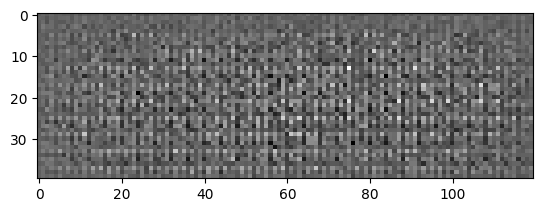

In [ ]:
generator = make_generator_model()
noise = tf.random.normal([1, dim_z])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

generator_optimizer = tf.keras.optimizers.Adam(1e-5, beta_1=0.5, beta_2=0.9)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-5, beta_1=0.5, beta_2=0.9)

checkpoint_dir = '../dataset/checkpoint/wgan_gp/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

EPOCHS = 50000
num_examples_to_generate = 50
seed = tf.random.normal([num_examples_to_generate, dim_z])

restore = 1
training = 0
if restore==True: checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
if training==True: loss_history = train(train_dataset, EPOCHS)

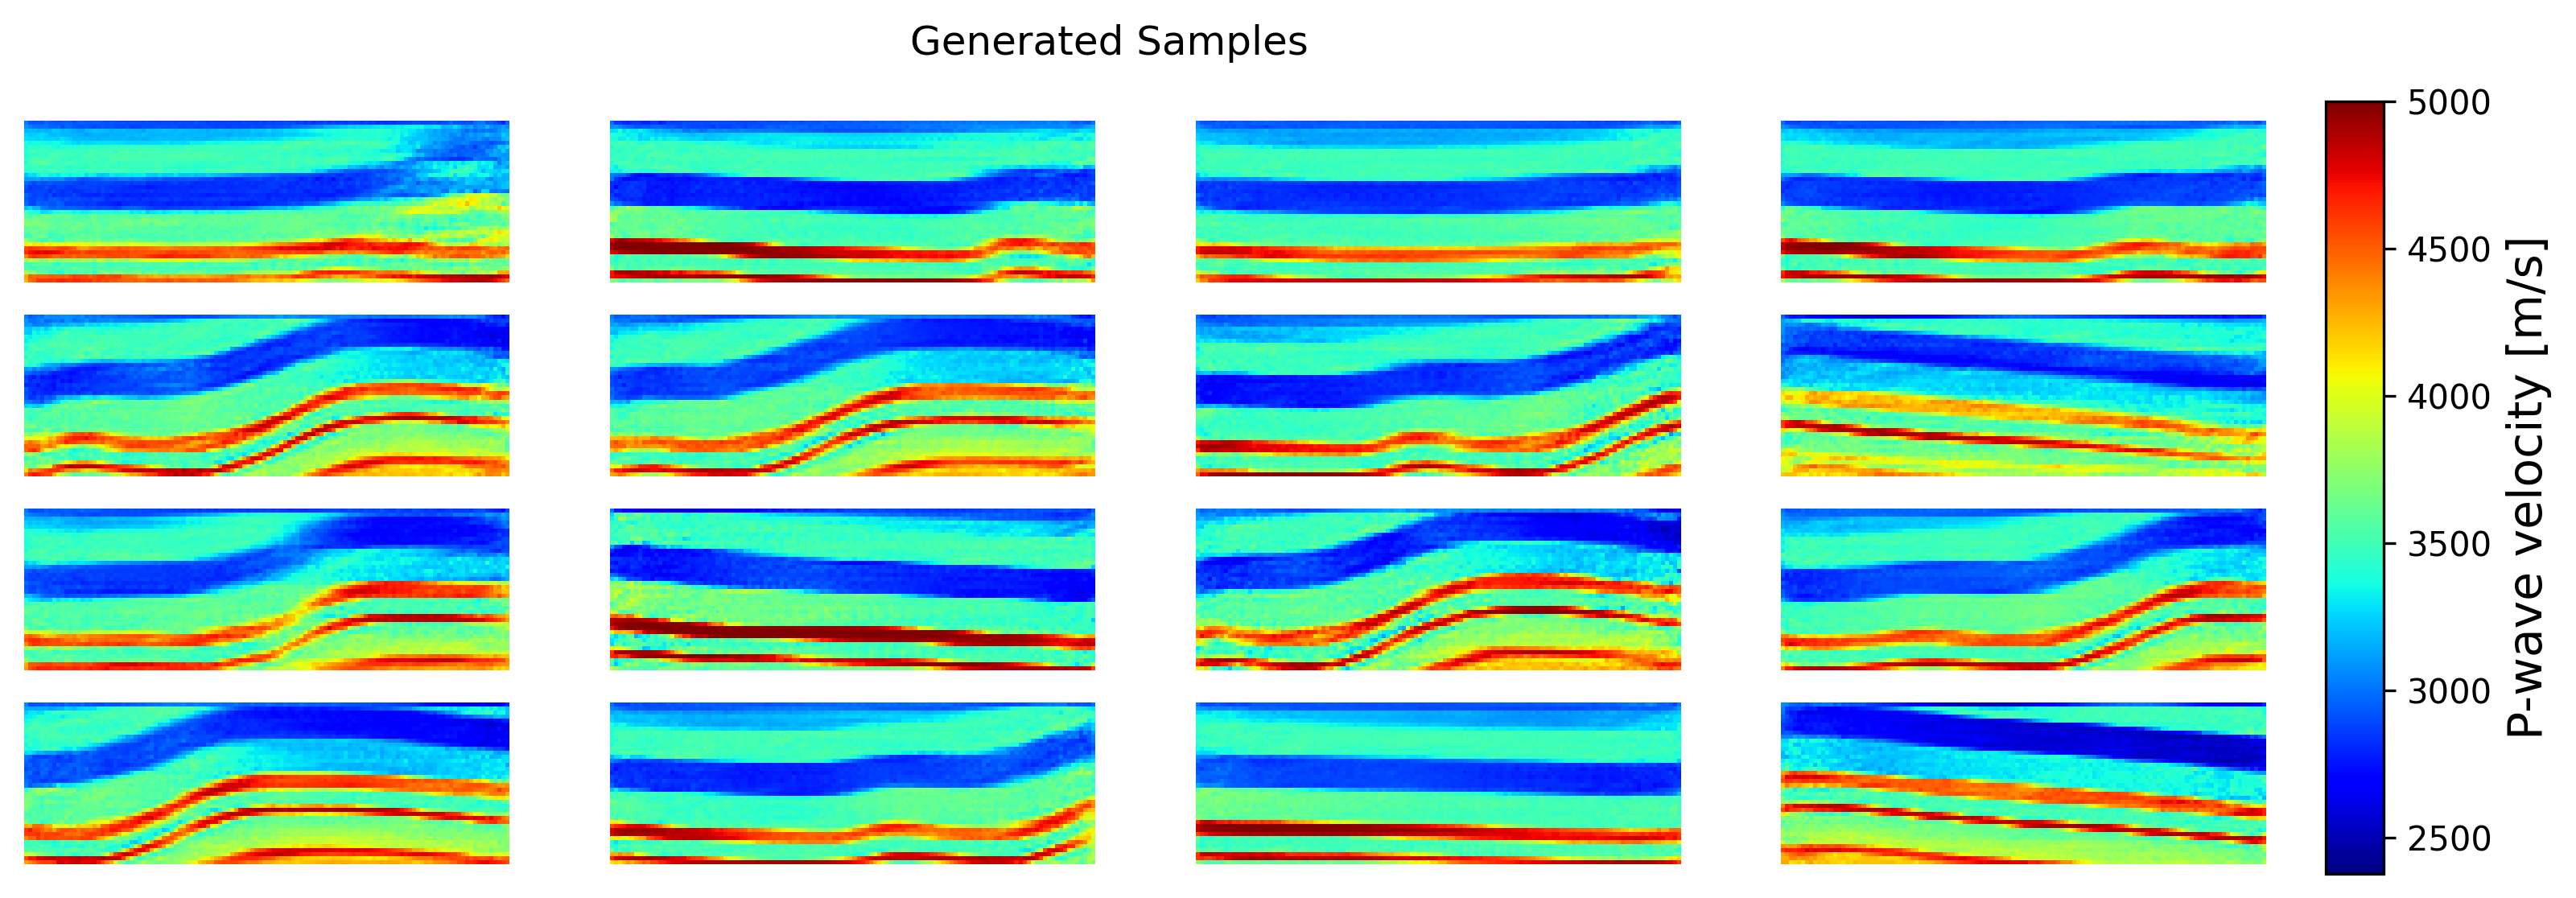

In [ ]:
seed = tf.random.normal([num_examples_to_generate, dim_z])
Gz = generator(seed, training=False)
fig = plt.figure(figsize=(12, 4),dpi=300)
plt.suptitle("Generated Samples")
for i in range(16):
  plt.subplot(4, 4, i+1)
  Gz_i = inverse_norm(Gz[i,:,:,0],vmin,vmax)
  plt.imshow(Gz_i,cmap='jet',vmin=vmin,vmax=vmax)
  plt.axis('off')
# Add a single colorbar for all subplots
cax = plt.axes([0.92, 0.1, 0.02, 0.8])  # [x, y, width, height]
cb = plt.colorbar(cax=cax)
cb.set_label("P-wave velocity [m/s]", fontsize=14)
plt.show()

# Forward Modeling

Min velocity: 2432.29  Max velocity 4850.00
dz,dx,dt (m): 9.504880859375 9.504880859375 0.0012094673270528794
Model dimension [nz,nx,nt]:  40 120 400


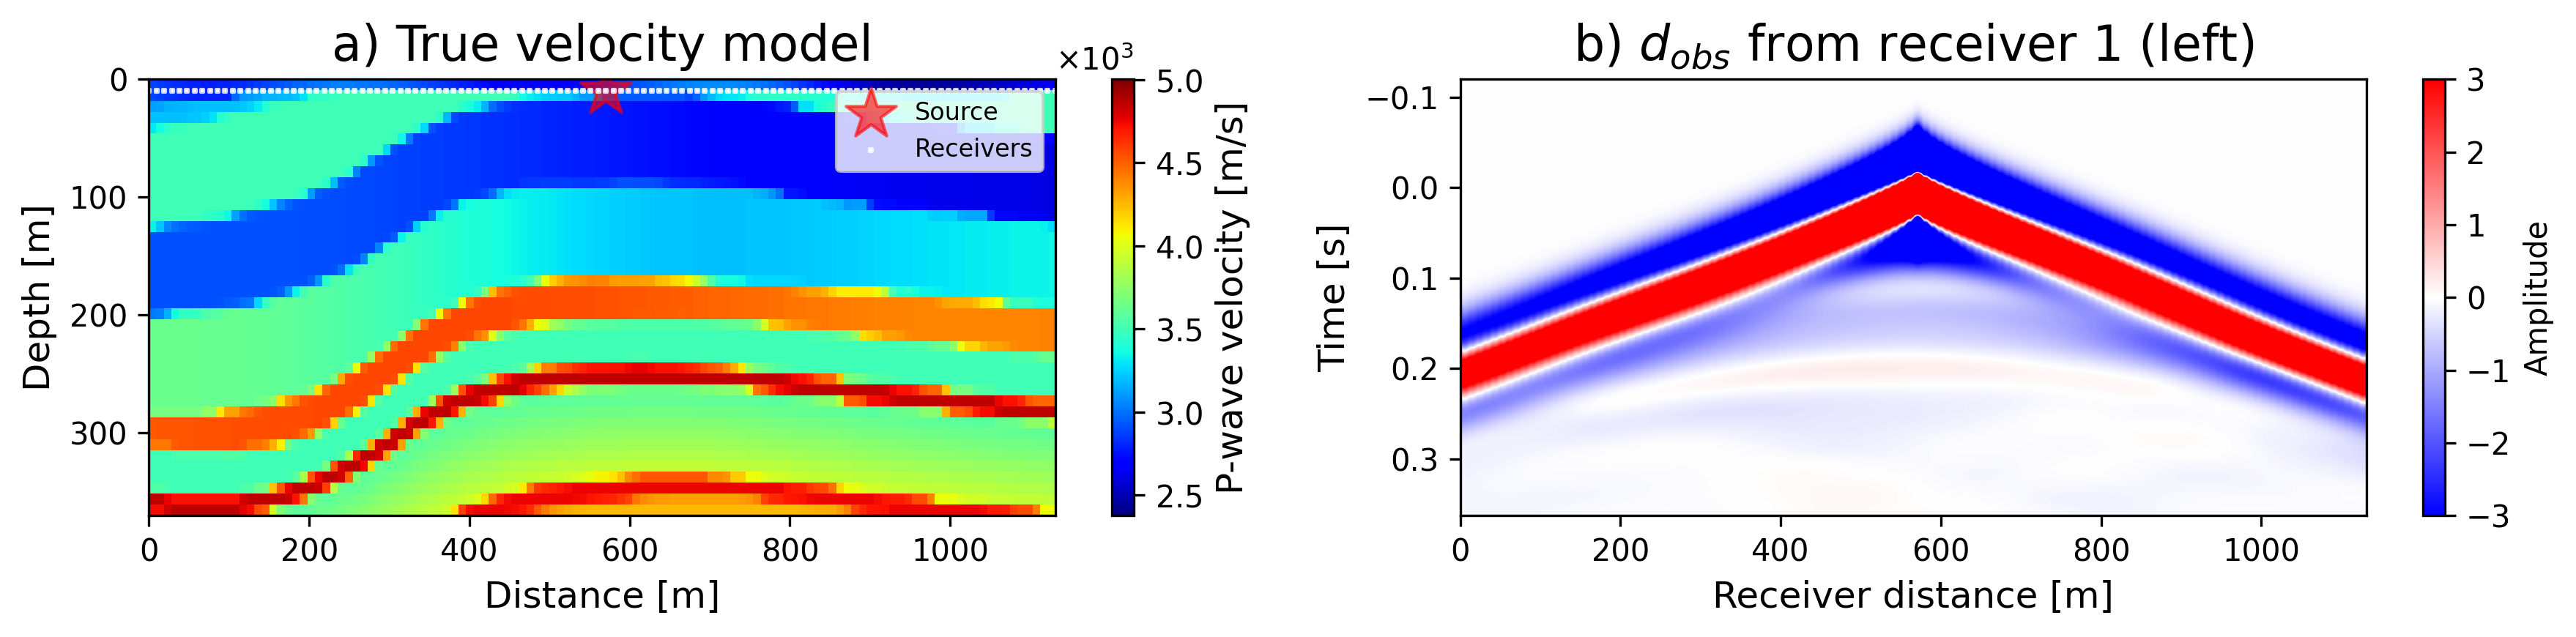

In [ ]:
def disp_fwd(vel, d_obs):
	plt.figure(figsize=(12,3), dpi=300)
	plt.subplot(1,2,1)
	plt.imshow(vel.reshape((nz,nx)),vmin=vmin,vmax=vmax,cmap='jet',extent=[ax[0],ax[-1],az[-1],az[0]], aspect='auto')
	cbar = plt.colorbar()
	cbar.formatter.set_useMathText(True)
	cbar.formatter.set_scientific(True)
	cbar.formatter.set_powerlimits((-1, 1))  # Adjust these limits as needed
	cbar.update_ticks()
	cbar.set_label("P-wave velocity [m/s]", fontsize=labelsize-4)
	plt.scatter(dz*zxsrc[1,:],dx*zxsrc[0,:],marker='*',color='r',s=300,alpha=0.6,label="Source")
	plt.scatter(dz*zxrec[1,:],dx*zxrec[0,:],marker='s',color='w',s=1,alpha=0.8,label="Receivers")
	plt.legend(loc='upper right',fontsize=labelsize-8)
	plt.xlabel('Distance [m]', fontsize=labelsize-4)
	plt.ylabel('Depth [m]', fontsize=labelsize-4)
	plt.title("a) True velocity model",fontsize=labelsize)

	plt.subplot(1,2,2)
	seismic_data = tf.transpose(d_obs[0]).numpy()
	# plt.imshow(ls.hillshade(seismic_data, vert_exag=1, fraction=1.0), cmap='gray',vmin=-5,vmax=5,extent=[ax[0], ax[-1],at[-1], at[0]], aspect='auto')
	plt.imshow(seismic_data,cmap='bwr',vmin=-3,vmax=3,extent=[ax[0], ax[-1],at[-1], at[0]], aspect='auto')
	cbar = plt.colorbar()
	cbar.set_label("Amplitude")
	plt.title("b) $d_{obs}$ from receiver 1 (left)", fontsize=labelsize)
	plt.xlabel('Receiver distance [m]', fontsize=labelsize-4)
	plt.ylabel('Time [s]', fontsize=labelsize-4)
	plt.tight_layout()
	plt.show()


# Initialize the model axis az, ax, at
nz,nx,nt = 40,120,400
# vmin,vmax = 1000,4500
izsrc, ixsrc = [1], [nx//2]
next = 100

# v_ref = cropped_images[860,:,:,0].numpy()
v_ref = cropped_images[200,:,:,0].numpy()

# seed = tf.random.normal([num_examples_to_generate, dim_z])
# Gz = generator(seed, training=False)
# Gz_i = inverse_norm(Gz[0,:,:,0],vmin,vmax)
# v_ref = Gz_i.numpy().flatten()
# mu=0

print("Min velocity: %.2f " % v_ref.min()+" Max velocity %.2f" % v_ref.max())

az, ax, at, next, wsrc, zxsrc = prop.defmodel(
                      vmin=vmin, vmax=vmax, fmax=25, # key parameters
                      nz=nz, nx=nx, nt=nt, # number of indices
                      izsrc=izsrc, ixsrc=ixsrc,  # define source coordinates z, x
                      ext=next)
dz,dx,dt = az[1]-az[0],ax[1]-ax[0],at[1]-at[0]

# Set sourse and receiver coordinates: shape=(2,nrec)
zxsrc = np.array([[1], [3*nx//6]]) # Single Sourse
# zxsrc = np.array([[1,1,1,1,1], [nx//6,2*nx//6,3*nx//6,4*nx//6,5*nx//6]])
zxrec = np.vstack((np.ones(nx), np.arange(0,nx))).astype(int) # Receivers everywhere at top

nsrc = zxsrc.shape[1]
d_obs = []
for i in range(nsrc):
  zxsrci = tf.expand_dims(zxsrc[:,i],-1)
  p, d_obs_i = prop.prop2d(wsrc, zxsrci, zxrec, v_ref, at, az, ax, next, device)
  d_obs.append(d_obs_i)

disp_fwd(v_ref, d_obs)

# Conditional Generator

## Clone pre-trained generator

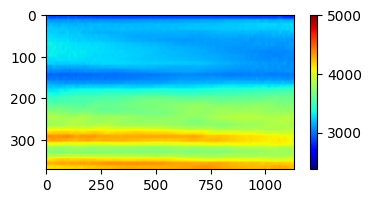

In [ ]:
# Clone pre-trained generator
cond_generator = tf.keras.models.clone_model(generator)  # Clone generator
cond_generator.set_weights(generator.get_weights()) # Clone weights
# print(conditional_generator.summary())

loss_tracker = []
BATCH_SIZE = 200
noise_batch = tf.random.normal([BATCH_SIZE, dim_z])

epoch_vels = []
for j in range(BATCH_SIZE):
  # Generate a new image
  seed = noise_batch[j:j+1,:]
  Gz = cond_generator(seed, training=False)
  Gz = inverse_norm(Gz[0,:,:,0],vmin,vmax)
  vel = tf.reshape(Gz, -1)
  epoch_vels.append(vel)
v_init = tf.reduce_mean(epoch_vels,axis=0)

plt.figure(figsize=(4,2),dpi=100)
plt.imshow(tf.reshape(v_init, [nz,nx]),vmin=vmin,vmax=vmax,cmap='jet',extent=[ax[0],ax[-1],az[-1],az[0]], aspect='auto')
plt.colorbar()

## Clone Generator

In [ ]:
# Clone pre-trained generator
cond_generator = tf.keras.models.clone_model(generator)  # Clone generator
cond_generator.set_weights(generator.get_weights()) # Clone weights

# Creating a custom layer with keras API.
dim_w = dim_z

@tf.custom_gradient
def dJ_dm(vel):
    loss_J = prop.misfit(vel.numpy(),d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device)
    loss_J = tf.cast(loss_J, tf.float32)

    def grad_fn(upstream):
        grad = prop.adjoint_gradient(vel.numpy(),d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device)
        return upstream * tf.cast(grad, tf.float32)
    return loss_J, grad_fn


BATCH_SIZE = 16
loss_tracker = []
sigma2 = 1e-1  # Noise level
epoch_vels = []

# Compute initial mean velocity
for _ in range(BATCH_SIZE):
  print('.',end='')
  # Pass noise through Normalizing Flow
  w = tf.random.normal([1, n_dim])
  noise_z = flow(w)
  # Generate image from I(w)
  Gz = cond_generator(noise_z, training=False)
  Gz = inverse_norm(Gz[0,:,:,0],vmin,vmax)
  m = tf.reshape(Gz, -1)
  # Save generated velocity fields and loss
  epoch_vels.append(m)

v_init = tf.reduce_mean(epoch_vels,axis=0)

................

## Create Normalizing Flow (RealNVP)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import tensorflow_probability as tfp

tfd = tfp.distributions
tfb = tfp.bijectors

# Creating a custom layer with keras API.
output_dim = 256
reg = 0.01

def Coupling(input_shape):
    input = keras.layers.Input(shape=input_shape)

    t_layer_1 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(input)
    t_layer_2 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(t_layer_1)
    t_layer_3 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(t_layer_2)
    t_layer_4 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(t_layer_3)
    t_layer_5 = keras.layers.Dense(
        input_shape, activation="linear", kernel_regularizer=regularizers.l2(reg)
    )(t_layer_4)

    s_layer_1 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(input)
    s_layer_2 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(s_layer_1)
    s_layer_3 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(s_layer_2)
    s_layer_4 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(s_layer_3)
    s_layer_5 = keras.layers.Dense(
        input_shape, activation="tanh", kernel_regularizer=regularizers.l2(reg)
    )(s_layer_4)

    return keras.Model(inputs=input, outputs=[s_layer_5, t_layer_5])



class RealNVP(keras.Model):
    def __init__(self, num_coupling_layers=6):
        super().__init__()
        self.num_coupling_layers = num_coupling_layers

        # Distribution of the latent space.
        self.distribution = tfp.distributions.MultivariateNormalDiag(
            loc=tf.zeros(n_dim), scale_diag=tf.ones(n_dim)
        )

        fraction_masked = 0.5
        a = int(fraction_masked*n_dim)
        b = n_dim - a
        print(a,b)

        self.masks = np.array(
            [([0]*a + [1]*b),([1]*a + [0]*b)] * (num_coupling_layers // 2),
            dtype="float32"
        )
        self.layers_list = [Coupling(n_dim) for i in range(num_coupling_layers)]


    def call(self, x, training=True):
        log_det_inv = 0
        direction = 1
        if training:
            direction = -1
        for i in range(self.num_coupling_layers)[::direction]:
            x_masked = x * self.masks[i]
            reversed_mask = 1 - self.masks[i]
            s, t = self.layers_list[i](x_masked)
            s *= reversed_mask
            t *= reversed_mask
            gate = (direction - 1) / 2
            x = (
                reversed_mask
                * (x * tf.exp(direction * s) + direction * t * tf.exp(gate * s))
                + x_masked
            )
            log_det_inv += gate * tf.reduce_sum(s, [1])

        return x

n_dim=100
fraction_masked=0.5
flow = RealNVP(num_coupling_layers=6)
w = tf.random.normal([32,n_dim])
print(flow(w).shape)
# print(flow.trainable_variables)

50 50
(32, 100)


## Apply gradient to Inference Network

Iteration 199


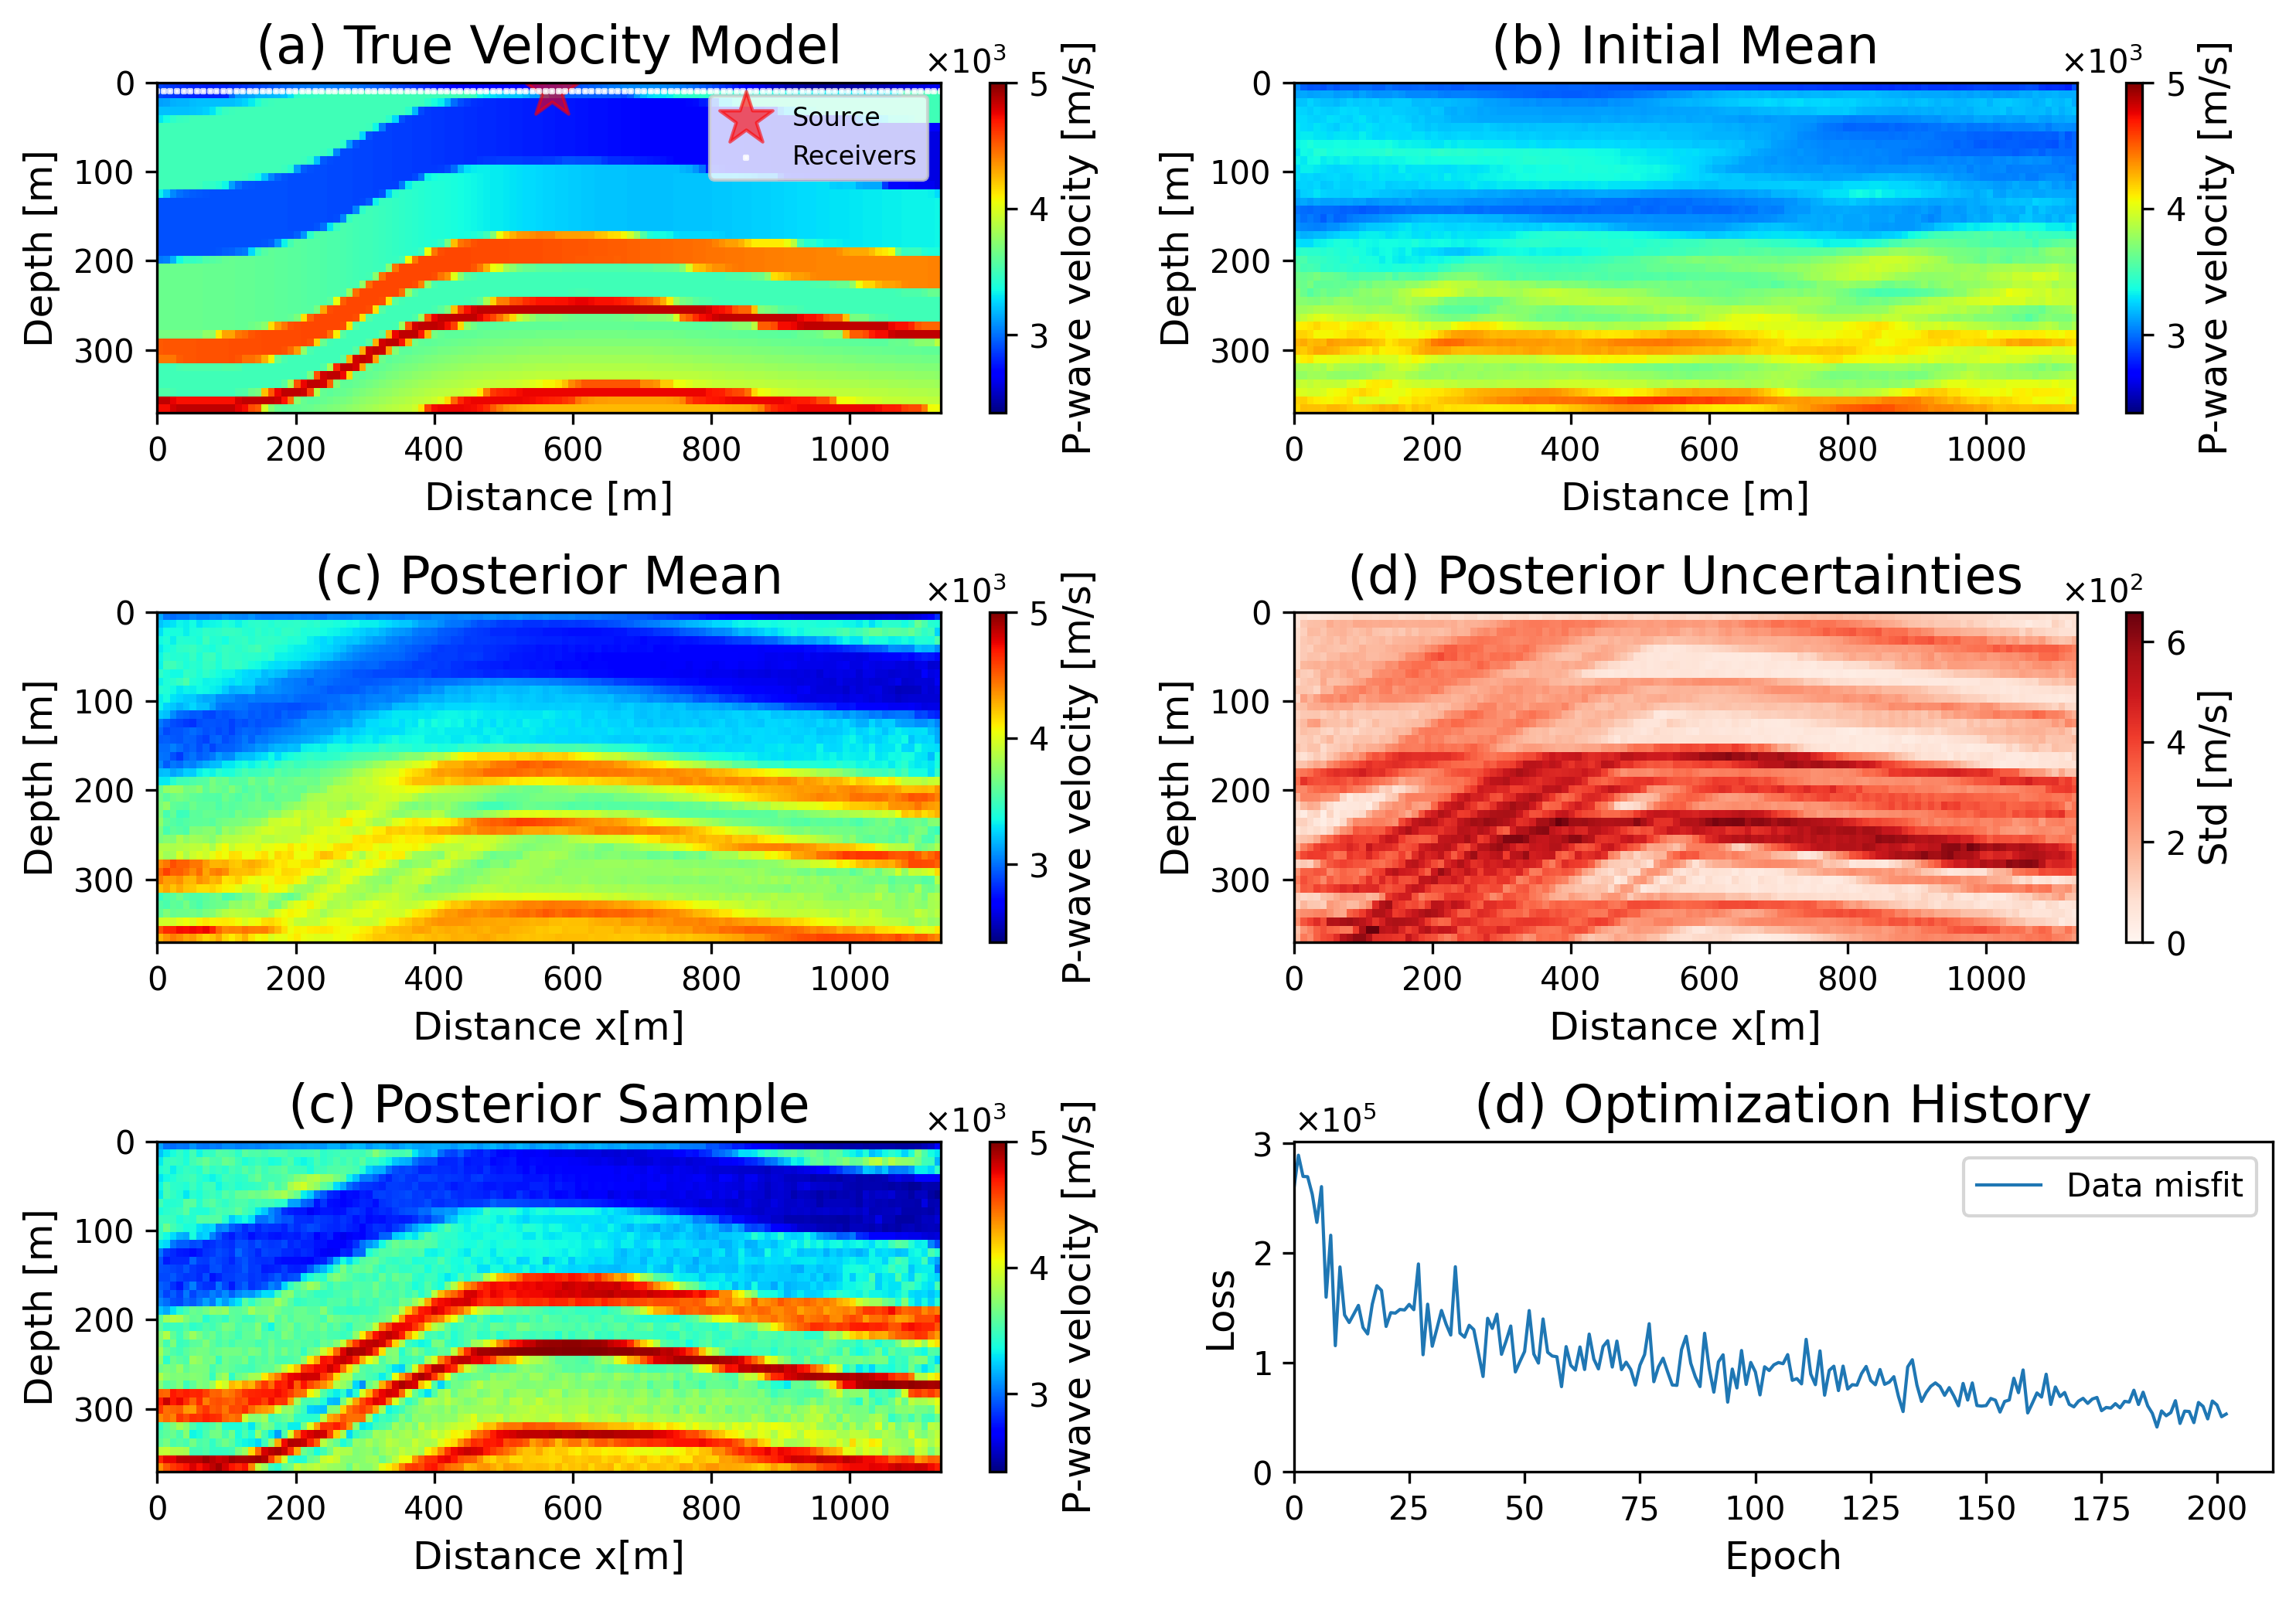

In [ ]:
def plot_loss(epoch_vels, loss_list):
    # Display current velocity field
    clear_output(wait=True)
    print('Iteration', int(i))

    plt.figure(figsize=(10,7), dpi=300)
    # Plot the true velocity
    plt.subplot(321)
    plt.imshow(v_ref.reshape((nz,nx)),vmin=vmin,vmax=vmax,cmap='jet',extent=[ax[0],ax[-1],az[-1],az[0]], aspect='auto')
    cbar = plt.colorbar()
    cbar.formatter.set_useMathText(True)
    cbar.formatter.set_scientific(True)
    cbar.formatter.set_powerlimits((-1, 1))  # Adjust these limits as needed
    cbar.update_ticks()
    cbar.set_label("P-wave velocity [m/s]", fontsize=labelsize-4)
    plt.scatter(dz*zxsrc[1,:],dx*zxsrc[0,:],marker='*',color='r',s=300,alpha=0.6,label="Source")
    plt.scatter(dz*zxrec[1,:],dx*zxrec[0,:],marker='s',color='w',s=1,alpha=0.8,label="Receivers")
    plt.legend(loc='upper right',fontsize=labelsize-8)
    plt.xlabel('Distance [m]', fontsize=labelsize-4)
    plt.ylabel('Depth [m]', fontsize=labelsize-4)
    plt.title("(a) True Velocity Model",fontsize=labelsize)

    # Plot the initial velocity
    plt.subplot(322)
    plt.imshow(tf.reshape(v_init, [nz,nx]),vmin=vmin,vmax=vmax,cmap='jet',extent=[ax[0],ax[-1],az[-1],az[0]], aspect='auto')
    cbar = plt.colorbar()
    cbar.formatter.set_useMathText(True)
    cbar.formatter.set_scientific(True)
    cbar.formatter.set_powerlimits((-1, 1))  # Adjust these limits as needed
    cbar.update_ticks()
    cbar.set_label("P-wave velocity [m/s]", fontsize=labelsize-4)
    plt.xlabel('Distance [m]', fontsize=labelsize-4)
    plt.ylabel('Depth [m]', fontsize=labelsize-4)
    plt.title("(b) Initial Mean",fontsize=labelsize)

    # Plot the velocity field at current iteration
    plt.subplot(323)
    plt.imshow(post_mean.numpy().reshape((nz,nx)),vmin=vmin,vmax=vmax,cmap='jet',extent=[ax[0],ax[-1],az[-1],az[0]], aspect='auto')
    cbar = plt.colorbar()
    cbar.formatter.set_useMathText(True)
    cbar.formatter.set_scientific(True)
    cbar.formatter.set_powerlimits((-1, 1))  # Adjust these limits as needed
    cbar.update_ticks()
    cbar.set_label("P-wave velocity [m/s]", fontsize=labelsize-4)
    plt.xlabel('Distance x[m]', fontsize=labelsize-4)
    plt.ylabel('Depth [m]', fontsize=labelsize-4)
    plt.title("(c) Posterior Mean",fontsize=labelsize)

    # Plot the velocity field at current iteration
    plt.subplot(324)
    plt.imshow(post_std.numpy().reshape((nz,nx)),vmin=0,cmap='Reds',extent=[ax[0],ax[-1],az[-1],az[0]], aspect='auto')
    cbar = plt.colorbar()
    cbar.formatter.set_useMathText(True)
    cbar.formatter.set_scientific(True)
    cbar.formatter.set_powerlimits((-1, 1))  # Adjust these limits as needed
    cbar.update_ticks()
    cbar.set_label("Std [m/s]", fontsize=labelsize-4)
    plt.xlabel('Distance x[m]', fontsize=labelsize-4)
    plt.ylabel('Depth [m]', fontsize=labelsize-4)
    plt.title("(d) Posterior Uncertainties",fontsize=labelsize)

    # Plot the velocity field at current iteration
    plt.subplot(325)
    plt.imshow(epoch_vels[0].numpy().reshape((nz,nx)),vmin=vmin,vmax=vmax,cmap='jet',extent=[ax[0],ax[-1],az[-1],az[0]], aspect='auto')
    cbar = plt.colorbar()
    cbar.formatter.set_useMathText(True)
    cbar.formatter.set_scientific(True)
    cbar.formatter.set_powerlimits((-1, 1))  # Adjust these limits as needed
    cbar.update_ticks()
    cbar.set_label("P-wave velocity [m/s]", fontsize=labelsize-4)
    plt.xlabel('Distance x[m]', fontsize=labelsize-4)
    plt.ylabel('Depth [m]', fontsize=labelsize-4)
    plt.title("(c) Posterior Sample",fontsize=labelsize)

    # Display loss track
    plt.subplot(326)
    plt.plot(loss_list,lw=1)
    # Set the x-axis tick formatter to scientific notation
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-2,2))  # Adjust these limits as needed
    plt.gca().yaxis.set_major_formatter(formatter)
    plt.legend(['Data misfit'])
    plt.xlim(xmin=0)
    plt.ylim(ymin=0)
    plt.xlabel('Epoch', fontsize=labelsize-4)
    plt.ylabel('Loss', fontsize=labelsize-4)
    plt.title("(d) Optimization History",fontsize=labelsize)

    plt.tight_layout()
    plt.show()

def kth_nearest_neighbors(X, k):
    # Find the indices of the k-th nearest neighbors for each sample
    # distances: A tensor of pairwise distances (M, M)
    # k: The value of k for the k-th nearest neighbor
    M = X.shape[0]
    distance = []
    for i in range(M):
        dist_i = tf.sqrt(tf.reduce_sum((X - X[i,:])**2, axis=1))
        log_rho_i = tf.math.log(tf.sort(dist_i)[k+1])
        distance.append(log_rho_i)
    return dim_z * tf.reduce_mean(log_rho_i)

cond_generator_optimizer = tf.keras.optimizers.Adam(1e-4)
# Kozachenko-Leonenko estimator: k = sqrt(M)
k = int(np.round(np.sqrt(dim_z)))

for i in range(200):
  # grad = tape.gradient(J, v_gan)
  with tf.GradientTape(persistent=True) as tape:
    w = tf.random.normal([BATCH_SIZE, dim_w])
    noise_z = flow(w)
    epoch_losses = []
    epoch_vels = []
    for j in range(BATCH_SIZE):
      print('.',end='')
      noise_z_i = noise_z[j:j+1,:]
      # Generate image from I(w)
      Gz = cond_generator(noise_z_i, training=False)
      Gz = inverse_norm(Gz[0,:,:,0],vmin,vmax)
      m = tf.reshape(Gz, -1)
      # Forward propagation & Adjoint back propagation
      J = dJ_dm(m)
      neg_log_post = J/(1e-6+sigma2) + tf.reduce_sum(noise_z_i**2)
      # Save generated velocity fields and loss
      epoch_vels.append(m)
      epoch_losses.append(neg_log_post)

    # Compute Posterior Mean velocity
    post_mean = tf.reduce_mean(epoch_vels,axis=0)
    post_std = tf.math.reduce_std(epoch_vels,axis=0)

    # Negative Entropy loss
    entropy = kth_nearest_neighbors(noise_z, k)
    # Compute averate loss of this epoch's batch
    epoch_loss = tf.reduce_mean(epoch_losses) - entropy

  # Save loss
  loss_tracker.append(epoch_loss)
  plot_loss(epoch_vels, loss_tracker)

  # Compute gradient of loss w.r.t.
  grad = tape.gradient(epoch_loss, flow.trainable_variables)
  # print('Sum of dJ|dw',sum([tf.reduce_sum(tf.abs(g)) for g in grad]).numpy())
  cond_generator_optimizer.apply_gradients(zip(grad, flow.trainable_variables))

In [ ]:
nvp

<tfp.distributions._TransformedDistribution 'real_nvpMultivariateNormalDiag' batch_shape=[] event_shape=[100] dtype=float32>

## Posterior Samples

In [ ]:
fig = plt.figure(figsize=(12, 6),dpi=300)
plt.suptitle("Posterior Samples", fontsize=24)
for k in range(12):
  plt.subplot(4, 3, k+1)
  plt.imshow(epoch_vels[k].numpy().reshape((nz,nx)),cmap='jet',vmin=vmin,vmax=vmax,aspect='auto')
  plt.axis('off')
# Add a single colorbar for all subplots
cax = plt.axes([0.92, 0.1, 0.02, 0.8])  # [x, y, width, height]
cb = plt.colorbar(cax=cax)
cb.set_label("P-wave velocity [m/s]", fontsize=24)
plt.show()